## Monte Carlo Option Pricing
This script shows how to use Monte Carlo methods to price a financial derivative or option.  An option gives the right, but not the
obligation, to conduct some transaction at a future date.

In [101]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt

### Plot historical data
Here we load in the historical adjusted daily closing prices of a stock and plot the most recent year's data.  The data were obtained from <http://finance.yahoo.com> for GOOG for the period ending May 19, 2015.

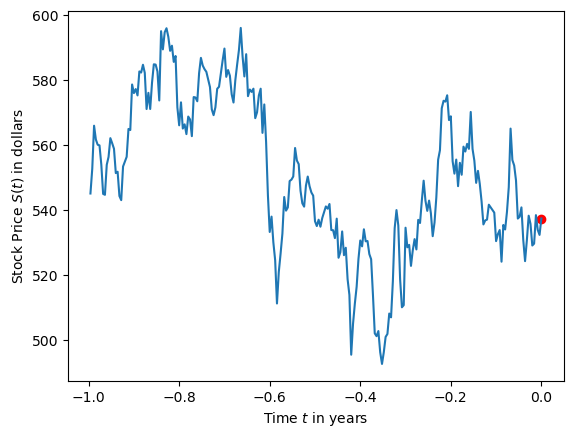

In [102]:
# Load the data into a NumPy array
data = np.loadtxt('stockPriceHistory.txt')
S0 = data[len(data)-1] # stock price today
Delta = 1/250 # daily time increment in years
timeBefore = np.arange(-249, 1) * Delta  #daily monitoring for one year prior to today
plt.plot(timeBefore, data) # plot history
plt.scatter(0,S0,color = 'red') # plot initial price
plt.xlabel('Time $t$ in years')
plt.ylabel('Stock Price $S(t)$ in dollars')
plt.show()

### Estimate drift and volatility
Although we know the past, we do not know the future.  However, we can
use historical data to build a random (stochastic) model of the future.
Let $S(t)$ denote the price of this stock at time $t$ measured in
years.  The geometric Brownian motion model of a stock price says that 
 
$$ S(t+\Delta ) = S(t) \exp( \Delta m + \sigma \sqrt{\Delta} Z ), $$

where 

* $\Delta = 1/250$ is the _time increment_ (250 trading days per year), 
* $m$ is a constant _drift_, 
* $\sigma$ is the constant _volatility_, and 
* $Z$ is a Gaussian (normal) random variable with zero mean and unit variance. 

For the data that we have,$(t_j,S(t_j)),\ j=-249, -248, \ldots, 0$,
the relationship between stock prices at successive times can be written
as

$$ \log\biggl(\frac{S(t_{j+1})}{S(t_{j})} \biggr) = \log(S(t_{j+1} )) -
\log(S(t_j)) = \Delta m + \sigma \sqrt{\Delta} Z_j, $$

where the $Z_j$ are independent and identically distributed (IID)
$\mathcal{N}(0,1)$.  This means that we can estimate $\Delta m$ and
\(\sigma^2 \Delta\) by the sample mean and variance of the difference of the logged stock price data:

$$ \Delta m  = \frac{1}{249} \sum_{j=-249}^{-1}
 \log\biggl(\frac{S(t_{j+1})}{S(t_{j})} \biggr), \qquad  \sigma^2 \Delta =
 \frac{1}{248} \sum_{j=-249}^{-1}
 \biggl[\log\biggl(\frac{S(t_{j+1})}{S(t_{j})} \biggr) - \Delta m
 \biggr]^2, \qquad t_j = \frac{j}{250}.$$

In [103]:
diffLogStockPrice = np.diff(np.log(data)) # difference of the log of the stock prices
scDrift = np.mean(diffLogStockPrice) # sample mean
drift = scDrift/Delta # estimated drift
scVolatility = np.std(diffLogStockPrice)  # sample standard deviation
volatility = scVolatility/np.sqrt(Delta) # estimated volatility
print("The estimated drift is ",f"{drift:.4f}", "and volatility is", f"{volatility:.4f}")

The estimated drift is  -0.0143 and volatility is 0.1961


The interesting part comes next!

### Future price movement
Next we use these estimated quantities to plot scenarios representing
what this stock might do in the future.  We set up times looking half a
year, $T$, ahead: 

In [104]:
d = 125 # look at d new time steps
timeAfter = np.arange(0,d+1) * Delta # time steps ahead
timeFinal = timeAfter[d-1]  # final time

Next we program a function that computes %n% possible future scenarios,
i.e., stock price paths, $S(T/d), S(2T/d), \ldots, S(T)$:

In [105]:
# Define a function of sample size
SVal = lambda n: S0*np.exp(drift*timeAfter + scVolatility*np.cumsum(np.random.randn(n,d+1),axis = 1))
n1 = 20 # small number of paths
stockVal = SVal(n1) # generate some paths into the future

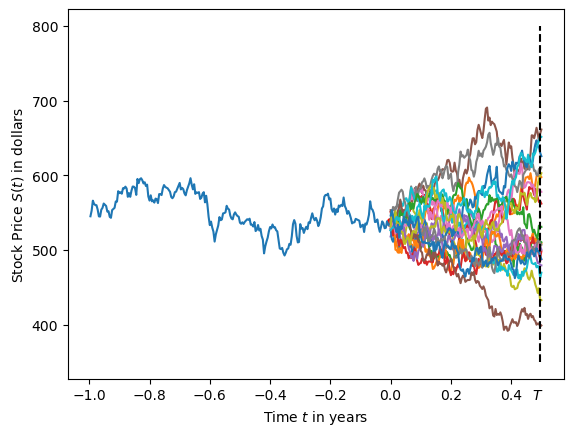

In [106]:
plt.plot(timeBefore, data) # plot history
plt.scatter(0,S0,color = 'red') # plot initial price
# plot twenty paths
for i in range(n1):
    plt.plot(timeAfter, stockVal[i])
plt.plot([timeFinal,timeFinal],[350,800],color = 'black', linestyle ='--')
plt.text(0.47,300,'$T$') # label the final time)
plt.xlabel('Time $t$ in years')
plt.ylabel('Stock Price $S(t)$ in dollars')
plt.show()

Which one of these is correct?  In fact, there are infinitely many possibilities.  This time let's plot more and look at the histogram.

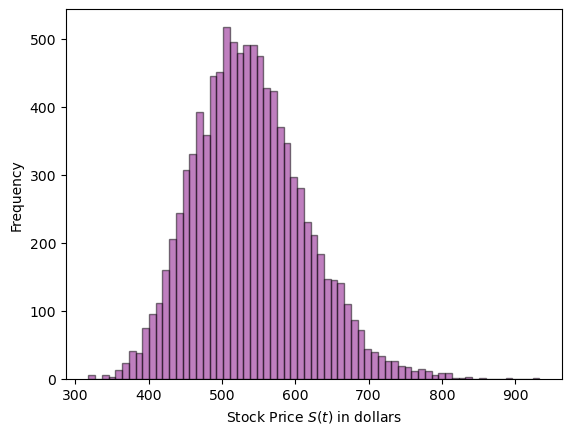

In [109]:
n = int(1e4)
stockValLargeSample = SVal(n)
plt.hist(stockValLargeSample[:,d], bins='auto', alpha=0.5, color='purple', edgecolor='black')
plt.xlabel('Stock Price $S(t)$ in dollars')
plt.ylabel('Frequency')
plt.show()

Note that this distribution of final stock prices is skewed towards the
higher values.  The value of $S(T)$ can be arbitrarily high, but may be
no less than zero.

### European option pricing
A European option comes in two types, call and put, and pays an amount at
the time of expiry, $T$.  The payoff depends on the final price of the
stock:

$$ \begin{array}{rcc}
 & \text{call} & \text{put} \\ \hline
 \text{payoff} & \max(S(T) - K,0) & \max(K - S(T),0) 
 \end{array}
$$

Here, $K$ denotes an agreed upon _strike price_.  The future stock 
price path is a random (stochastic) process, so $S(T)$ is random, and
the option payoff is random. Although we cannot know the actual future
payoff, we can try to compute the fair price of the option, which is the
expected value or mean of the payoff.  In fact, there is a small wrinkle.
Because money today is generally worth more than money in the future, the
fair price of the option is the expected value of the payoff times a
discounting factor that depends on the prevailing riskless interest rate,
$r$, i.e.,

$$ \text{fair price} = \mathbb{E}(\text{payoff}\times \mathrm{e}^{-rT}).$$

One way to estimate this mean is by the sample mean of the many payoffs.
Let $Y_i$ denote the payoff of the option according to the $i$ th
random stock path.  Then the approxmate fair price is

$$ \text{approximate fair price} = \frac{1}{n}\sum_{i=1}^n Y_i
 \mathrm{e}^{-rT} = \begin{cases} \displaystyle \frac{1}{n}\sum_{i=1}^n
 \max(S_i(T) - K,0) \mathrm{e}^{-rT}, & \text{call}, \\ \displaystyle
 \frac{1}{n}\sum_{i=1}^n \max(K - S_i(T),0) \mathrm{e}^{-rT}, &
 \text{put}. \end{cases} $$

There is a relationship between the riskless interest rate and the drift, which is
 
$$m = r - \frac{\sigma^2}{2} $$

This allows us to estimate the interest rate.  Let's try to price a
European call option with a strike price of $K = \$600$.

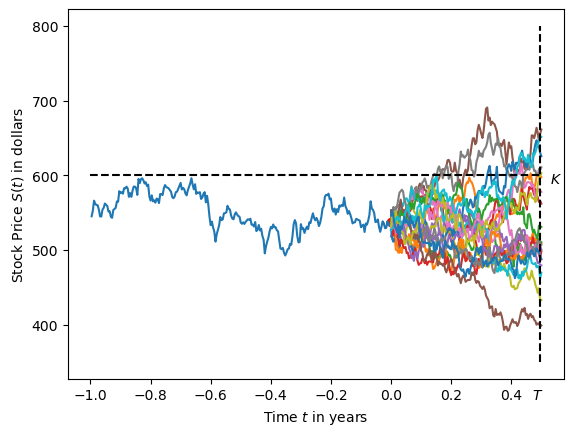

In [110]:
K = 600 # strike price
plt.plot(timeBefore, data) # plot history
plt.scatter(0,S0,color = 'red') # plot initial price
# plot twenty paths
for i in range(n1):
    plt.plot(timeAfter, stockVal[i])
plt.plot([timeFinal,timeFinal],[350,800],color = 'black', linestyle ='--')
plt.text(0.47,300,'$T$') # label the final time)
plt.plot([-1,timeFinal],[K,K],'--k') # plot the strike price
plt.text(0.53,590,'$K$') # label the final time
plt.xlabel('Time $t$ in years')
plt.ylabel('Stock Price $S(t)$ in dollars')
plt.show()

All the paths that end up above $K = \$600$ have a positive payoff.
Some paths will yield a positive payoff and others will not.

In [111]:
interest = drift + volatility**2/2 #interest rate
Yval = np.maximum(stockValLargeSample[:,d] - K, 0) * np.exp(-interest * timeFinal) #payoffs
euroCallPrice = np.mean(Yval) # estimated option price
CLTCIwidth = 2.58*np.std(Yval)/np.sqrt(n) # width of confidence interval
print("The option price = $",f"{ euroCallPrice:6.3f}"," +/- $", f"{ CLTCIwidth:6.3f}")

The option price = $  9.906  +/- $  0.727


We can try again.

In [112]:
# generate a large number of new paths
stockVal = SVal(n) 
Yval = np.maximum(stockVal[:,d] - K, 0) * np.exp(-interest * timeFinal)
euroCallPrice = np.mean(Yval) # estimated option price
CLTCIwidth = 2.58*np.std(Yval)/np.sqrt(n); # width of confidence interval
print("The option price = $",f"{ euroCallPrice:6.3f}"," +/- $", f"{ CLTCIwidth:6.3f}")

The option price = $  9.621  +/- $  0.712


These two approximations to the one option price are similar, but not the
same.  This is because we are using a random or Monte Carlo algrorithm

### Discussion

* The accuracy of our approximation to the option price depends on the
  number of stock price paths used, $n$.  We will discuss this dependence
  and how to choose $n$ to obtain the desired accuracy in MATH 565.

* This example looks at one of the simplest options to price.  However,
 note that one can consider options where they payoff is a more
 complicated function of the stock path, $S(T/d), S(2T/d), \ldots,
 S(T)$, and the Monte Carlo method will work the same way.  We explore
 some of these other options in MATH 565.

* The geometric Brownian motion model for the stock price may not capture
 the real world best.  Other models for the stock price path can be used,
 and the Monte Carlo method still works.  We explore some of these models
 in MATH 565.

* There are exact formulas for prices of European put and call options
 with this geometric Brownian motion stock price paths. One does not
 really need Monte Carlo to price them, but Monte Carlo is needed for more
 sophisticated options.  We considered European options for the sake of
 simplicity.

 * We used simple IID sampling.  If one is careful, other sampling schemes
 may be used to obtain the desired answer in less time, i.e., with fewer
 samples. We explore some of these methods for improving efficiency in
 MATH 565.


 _Author: Fred J. Hickernell, Yuhan Ding_
